# Privacy Preserving Linear Regression on `load_boston` Data using TensorFlow API

In [1]:
import math
# ML
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_boston

# crypto
from phe import paillier

## Part 1 - Train the model using plaintext

In [2]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features, labels):
    n_training_samples, n_dim = features.shape
    # concatenate a column of 1's (the bias factor) to the feature set
    f = np.reshape(np.c_[np.ones(n_training_samples), features], [n_training_samples, n_dim + 1])
    l = np.reshape(labels, [n_training_samples, 1])
    return f, l

In [3]:
# 1 - load the dataset
features, labels = load_boston(True)

# 2 - normalize the features
normalized_features = feature_normalize(features)

# 3 - append the bias column and reshape the data
f, l = append_bias_reshape(normalized_features, labels)
n_dim = f.shape[1]

# 4 - randomly partition the data into training and testing sets with 20% of data for testing
rnd_indices = np.random.rand(len(f)) < 0.8

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]

In [4]:
# 5 - set model parameters
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float)

X = tf.placeholder(tf.float64, [None, n_dim])
Y = tf.placeholder(tf.float64, [None, 1])
W = tf.Variable(tf.ones([n_dim, 1], tf.float64), dtype=tf.float64)

init = tf.global_variables_initializer()

In [5]:
# 6 - construct the TF dataflow graph
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [6]:
# 7 - train the model
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={
        X: train_x,
        Y: train_y
    })
    cost_history = np.append(cost_history, sess.run(cost, feed_dict={
        X: train_x,
        Y: train_y
    }))

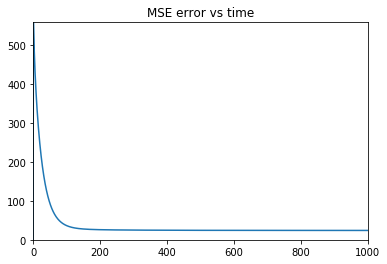

In [7]:
# 8 - plot cost history as training was performed
plt.plot(range(len(cost_history)), cost_history)
plt.title('MSE error vs time')
plt.axis([0, training_epochs, 0, np.max(cost_history)])
plt.show()

Mean square error: 12.291840630403929


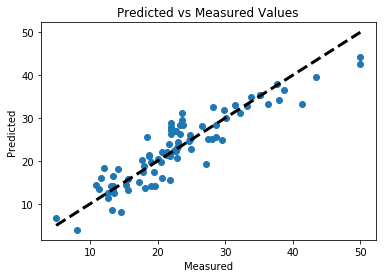

In [8]:
# 9 - test the model on testing data
pred_y = sess.run(y_, feed_dict = {
    X: test_x
})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print('Mean square error: {}'.format(sess.run(mse)))

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Predicted vs Measured Values')
plt.show()

In [9]:
weights = sess.run(W)
print('params:', weights)

params: [[ 2.25544664e+01]
 [-8.04952747e-01]
 [ 8.15826467e-01]
 [-2.28774521e-01]
 [ 7.03860023e-01]
 [-2.11212980e+00]
 [ 2.70441067e+00]
 [-5.12259036e-03]
 [-3.20576951e+00]
 [ 2.25494849e+00]
 [-1.45459482e+00]
 [-2.07673238e+00]
 [ 8.75226722e-01]
 [-3.84671370e+00]]


In [10]:
def manualPrediction(params, features):
    # Implements linear regression
    prediction = 0
    for param, feature in zip(params, features):
        prediction += param * feature
    return prediction

## Part 2 - Perform Prediction on Encrypted Data

In [11]:
# Generate Paillier keypair
pubkey, privkey = paillier.generate_paillier_keypair()

In [12]:
import copy

# Pick a feature row and modify it slightly to simulate an incoming, new data
newFeatures = copy.deepcopy(f[10]) # pick the 10th feature row to modify it
standardNormalRandom = [x/10 for x in np.random.randn(14, 1)]
for i in range(len(newFeatures)):
    newFeatures[i] += standardNormalRandom[i]

In [13]:
print('Natural data:\n', f[10])
print('\nModified data:\n', newFeatures)

Natural data:
 [ 1.         -0.39226356  0.04877224 -0.47665354 -0.27259857 -0.26515405
  0.13158947  0.91479923  1.21297914 -0.52300145 -0.57751897 -1.50523663
  0.39302804  1.09292612]

Modified data:
 [ 0.97588627 -0.2707392  -0.08365523 -0.54611    -0.0461532  -0.26649617
  0.07936686  0.91578742  1.3106519  -0.45570968 -0.65775254 -1.63463868
  0.49898877  1.18833131]


In [14]:
# Encrypt the data
enc_newFeatures = np.array([pubkey.encrypt(x) for x in newFeatures])
enc_newFeatures = np.reshape(enc_newFeatures, (1, len(newFeatures)))[0]

In [15]:
enc_newFeatures

array([<phe.paillier.EncryptedNumber object at 0x12198bba8>,
       <phe.paillier.EncryptedNumber object at 0x11f863ba8>], dtype=object)

In [16]:
# Perform prediction over the trained model
pred_enc = manualPrediction(weights, enc_newFeatures)[0]
print(pred_enc)

In [17]:
privkey.decrypt(pred_enc)

18.013331450449925

In [18]:
sess.close()

In [19]:
labels[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])